# COVID-19 
(Previously known as nCoV-2019)
<img src='https://ars.els-cdn.com/content/image/3-s2.0-B9780443073670000409-f040-001-9780443073670.jpg'>

<b>Overview:</b> <br>
Model the growth of the COVID-19 viral infections in mainland China and outside the mainland.

<b>Data Source:</b> <br>
https://en.m.wikipedia.org/wiki/Timeline_of_the_2019–20_Wuhan_coronavirus_outbreak <br>
http://www.nhc.gov.cn/xcs/yqtb/list_gzbd.shtml <br>
https://bnonews.com/index.php/2020/02/the-latest-coronavirus-cases/ <br>
https://www.thelancet.com/pb-assets/Lancet/pdfs/S0140673620302117.pdf <br>
Clinical outcome (99 Cases)
<li> Remained in hospital 57 (58%)
<li> Discharged 31 (31%)
<li> Died 11 (11%)
<br>
https://jamanetwork.com/journals/jama/fullarticle/2761044 <br>
<li>In this single-center case series of 138 hospitalized patients with confirmed NCIP in Wuhan, China, presumed hospital-related transmission of 2019-nCoV was suspected in 41% of patients, 26% of patients received ICU care, and mortality was 4.3%.

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 28 08:19:13 2020
"""
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
#import packages
import smtx_ncov as sm
import pandas as pd
import numpy as np
import xlrd
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from tabulate import tabulate
from matplotlib import style
from matplotlib.pylab import rcParams
style.use('fivethirtyeight')
# style.use('ggplot')

In [2]:
df_csv=pd.read_csv(r'corona2.csv')
df_xls=pd.read_excel(r'Corona.xlsx')
#Eliminating sparse data
# df=df_xls[7:]

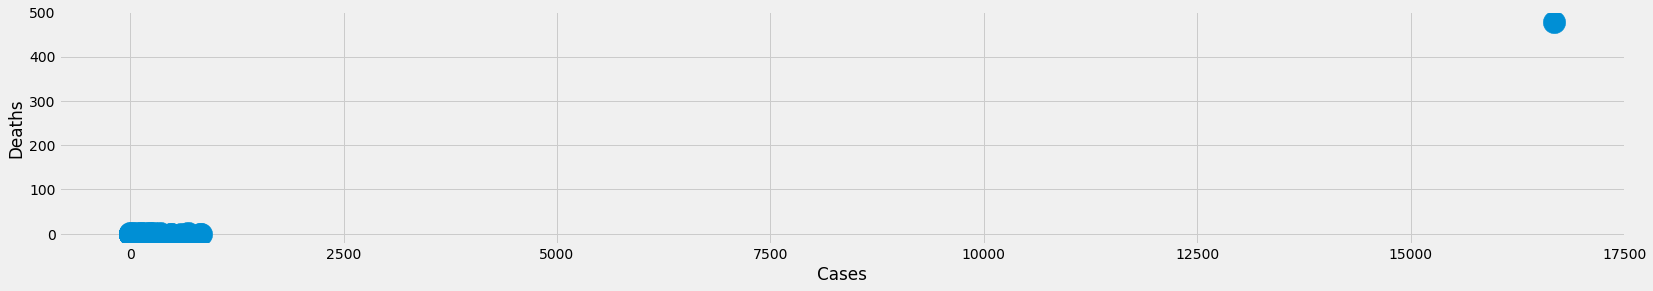

In [3]:
rcParams['figure.figsize'] = 25,4
df_csv.plot.scatter(x='Cases', y='Deaths', s=500)

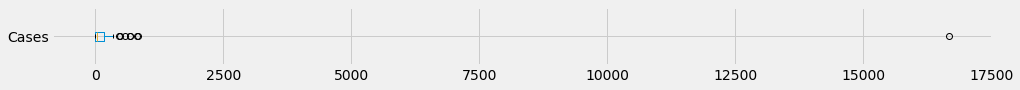

In [4]:
rcParams['figure.figsize'] =15,1
df_csv.boxplot(column='Cases', vert=False)

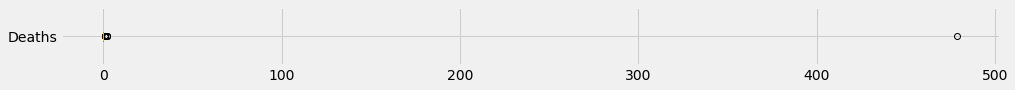

In [5]:
rcParams['figure.figsize'] =15,1
df_csv.boxplot(column='Deaths', vert=False)

In [6]:
df_csv_sorted = df_csv.sort_values(by='Cases', ascending=False)
print('Top 5 Regions by Cases')
df_csv_sorted.head(5)

Top 5 Regions by Cases


,REGION,Cases,Deaths,Notes,Links
0,Hubei province\n(including Wuhan),16678,479,"1,809 serious, 711 critical",Source
1,Zhejiang province,829,0,"43 serious, 15 critical",Source
2,Guangdong province,813,0,"60 serious, 26 critical",Source
3,Henan province,675,2,"39 serious, 15 critical",Source
31,Undisclosed,675,0,NaN,Source


In [7]:
# df=df.reset_index(drop=True)

In [8]:
# df_xls=df_xls[:22]

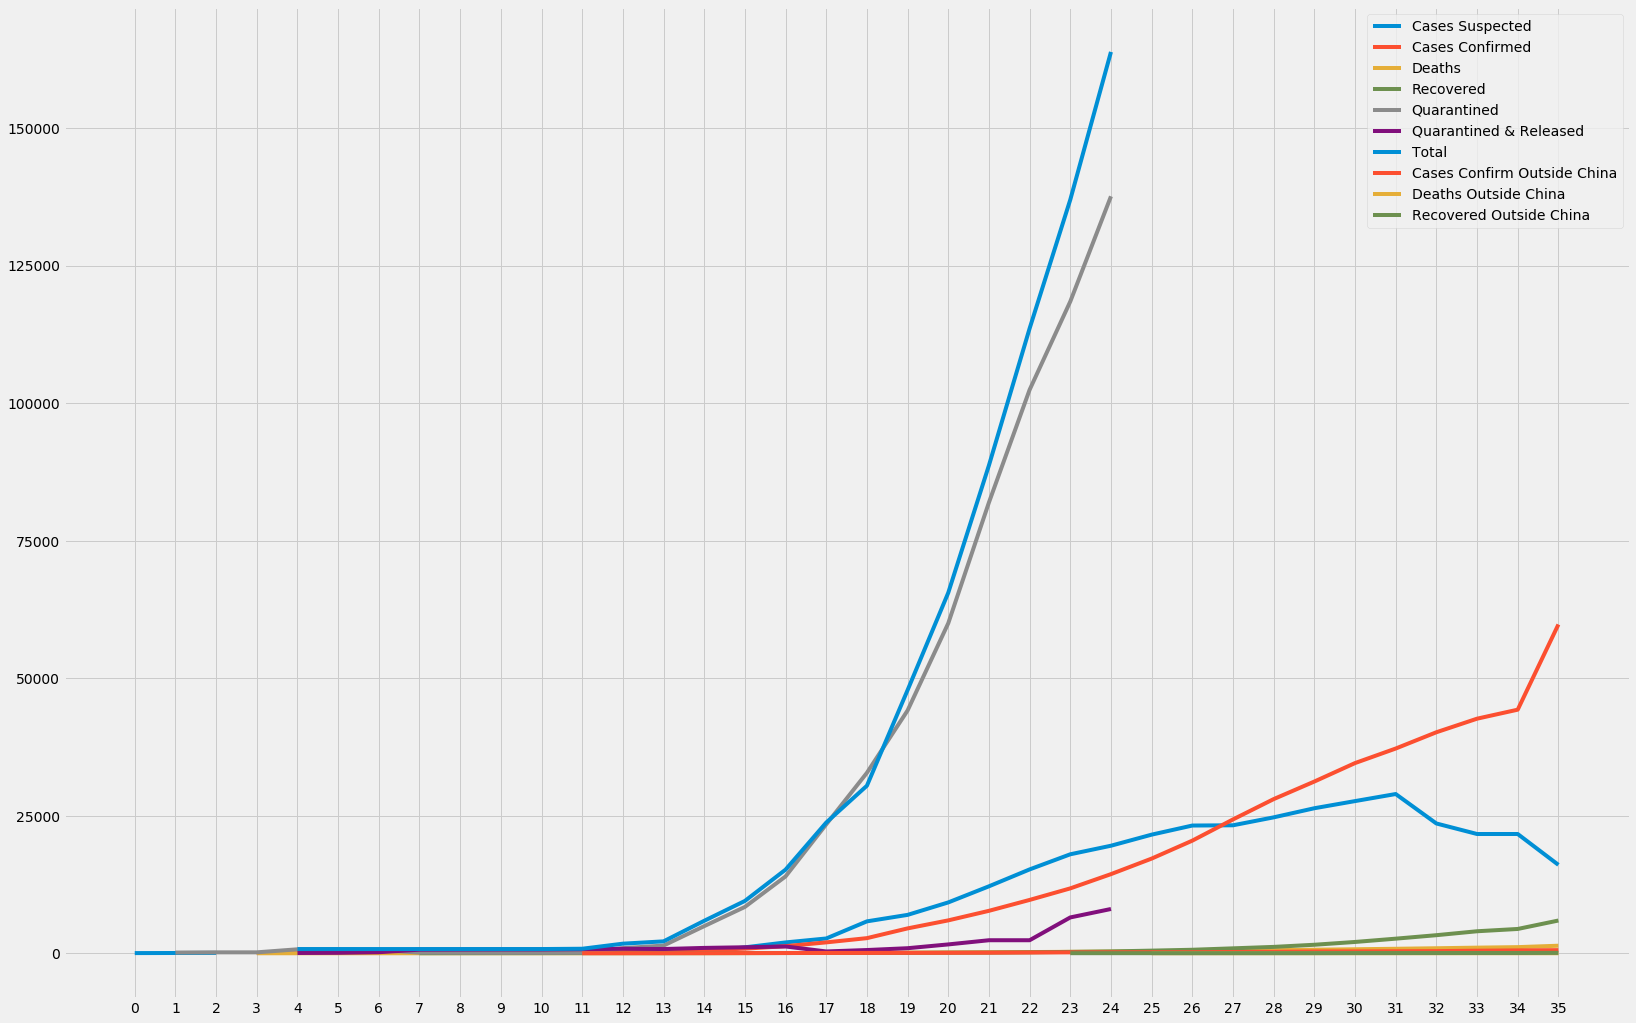

In [9]:
rcParams['figure.figsize'] = 25,17
df_xls.plot(xticks=df_xls.index)

In [10]:
df=df_xls.fillna(0)
df['Cases_pct'] = df['Cases Confirmed'].pct_change()
df['Deaths_pct'] = df['Deaths'].pct_change()
df['Cases_new'] = df['Cases Confirmed'].diff()
df['Deaths_new'] = df['Deaths'].diff()
df.tail(3)

,Date,Cases Suspected,Cases Confirmed,Deaths,Recovered,Quarantined,Quarantined & Released,Total,Source,Cases Confirm Outside China,Deaths Outside China,Recovered Outside China,Cases_pct,Deaths_pct,Cases_new,Deaths_new
33,2020.02.10,21675.0,42638.0,1016.0,3996.0,0.0,0.0,0.0,0,463.0,2.0,43.0,0.061412,0.118943,2467.0,108.0
34,2020.02.11,21675.0,44276.0,1110.0,4413.0,0.0,0.0,0.0,0,517.0,2.0,43.0,0.038416,0.092520,1638.0,94.0
35,2020.02.12,16067.0,59761.0,1367.0,5948.0,0.0,0.0,0.0,0,568.0,2.0,69.0,0.349738,0.231532,15485.0,257.0


CONFIRMED CASES - Comparison


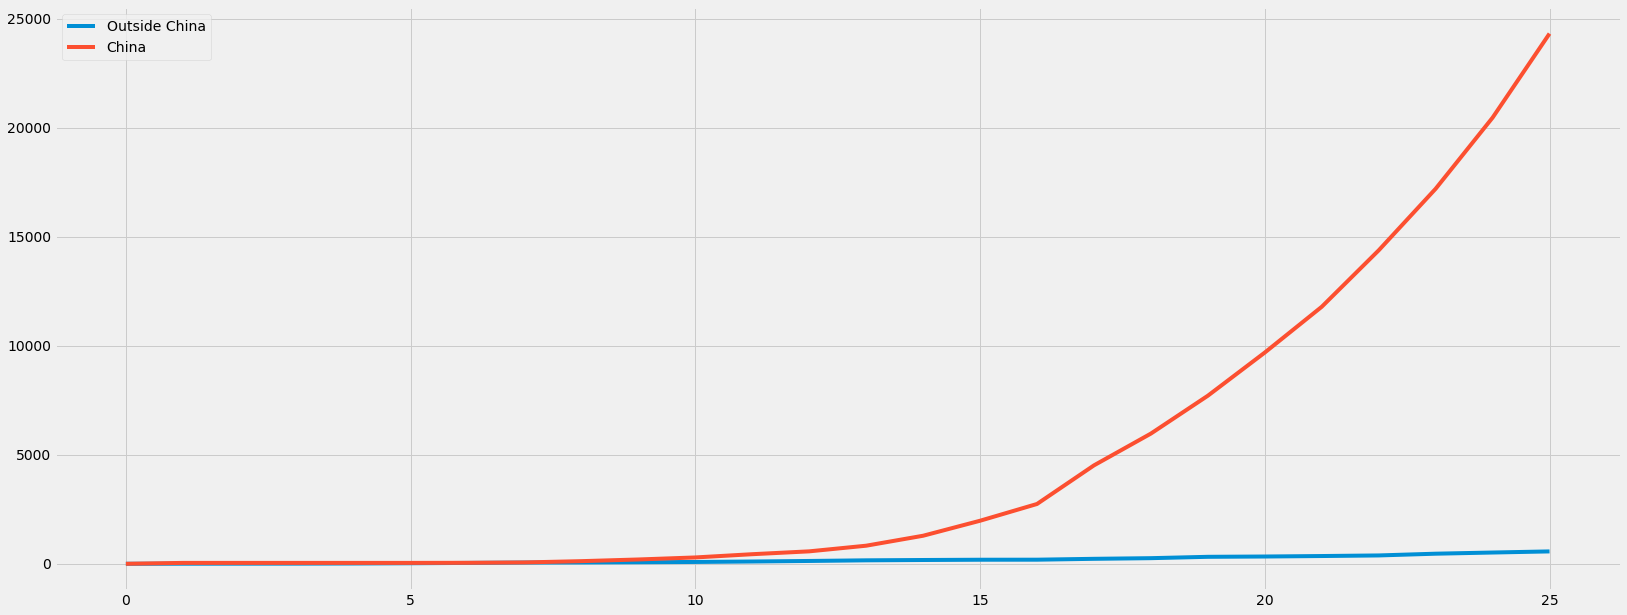

CONFIRMED CASES - Comparison of First 10 Days


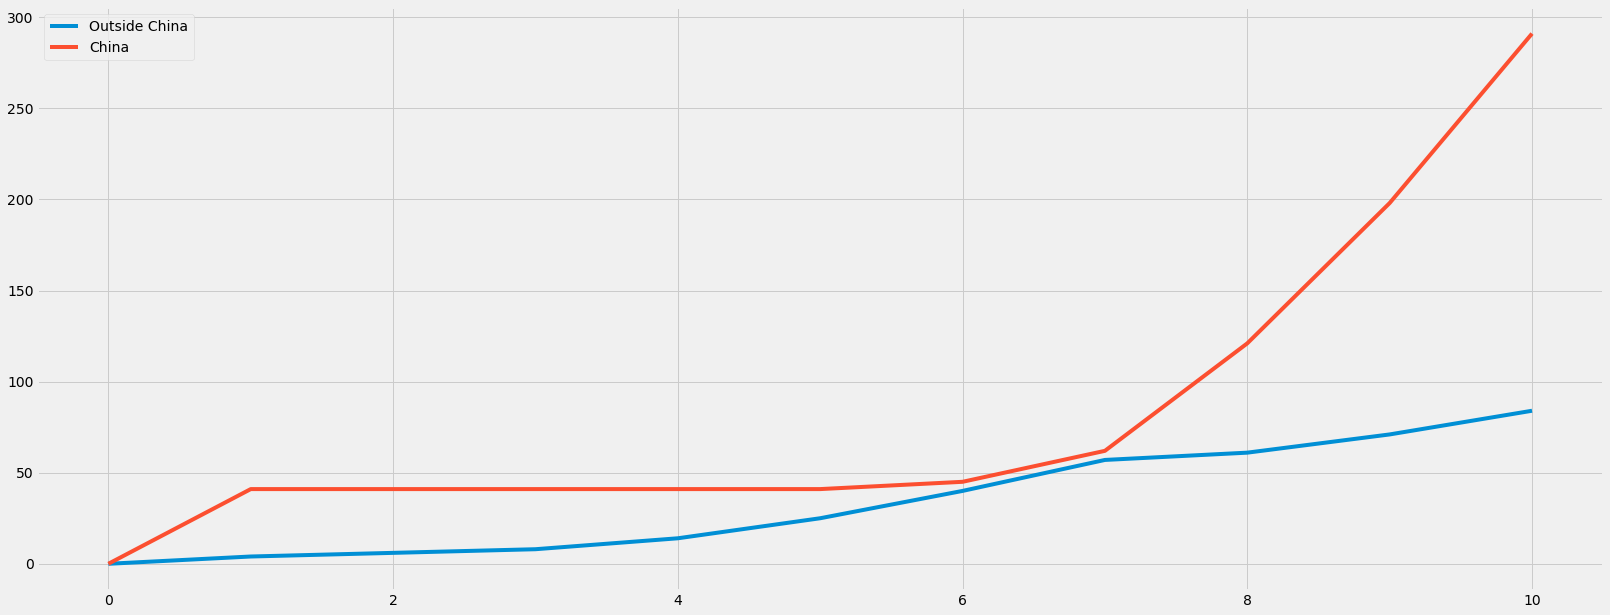

In [11]:
df_sc = df['Cases Suspected']
df_cc = df['Cases Confirmed']
df_cco = df['Cases Confirm Outside China']
print('CONFIRMED CASES - Comparison')
cco = np.array(df_cco[10:])
no_of_items = (np.size(cco))
cc = np.array(df_cc[2:(no_of_items+2)])
rcParams['figure.figsize'] = 25,10
plt.plot(cco, label = 'Outside China')
plt.plot(cc, label = 'China')
plt.legend()
plt.show()
print('CONFIRMED CASES - Comparison of First 10 Days')
cco = np.array(df_cco[10:21])
cc = np.array(df_cc[2:13])
rcParams['figure.figsize'] = 25,10
plt.plot(cco, label = 'Outside China')
plt.plot(cc, label = 'China')
plt.legend()
plt.show()

Percentage of cases outside China
*********************************
Current percentage = 0.9%


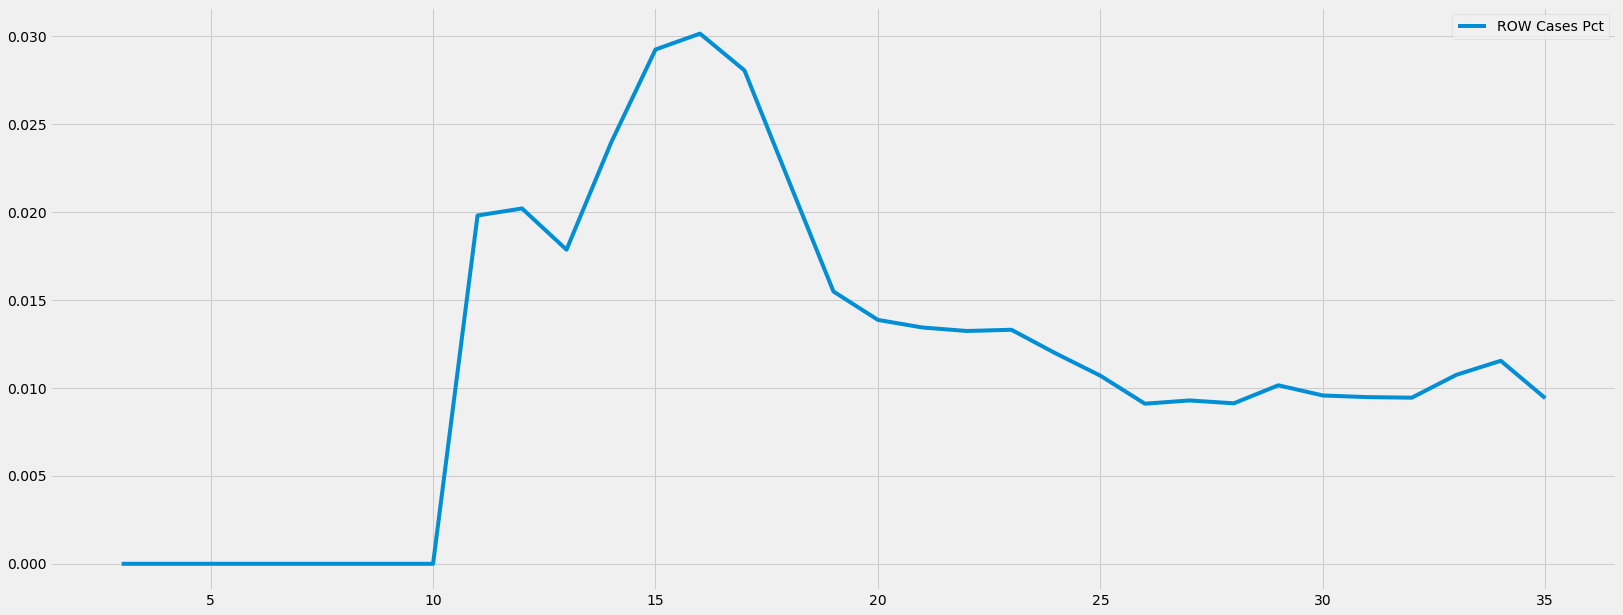

In [12]:
print('Percentage of cases outside China')
print('*********************************')
df['Total Cases'] = df['Cases Confirmed']+df['Cases Confirm Outside China']
df['China Cases Pct'] = df['Cases Confirmed']/df['Total Cases']
df['ROW Cases Pct'] = df['Cases Confirm Outside China']/df['Total Cases']
row_ratio = df['ROW Cases Pct'].tail(1).values[0]
print('Current percentage = {:0.1%}'.format(row_ratio))
df['ROW Cases Pct'].plot()
plt.legend()
plt.show()

RECOVERIES vs. FATALITIES


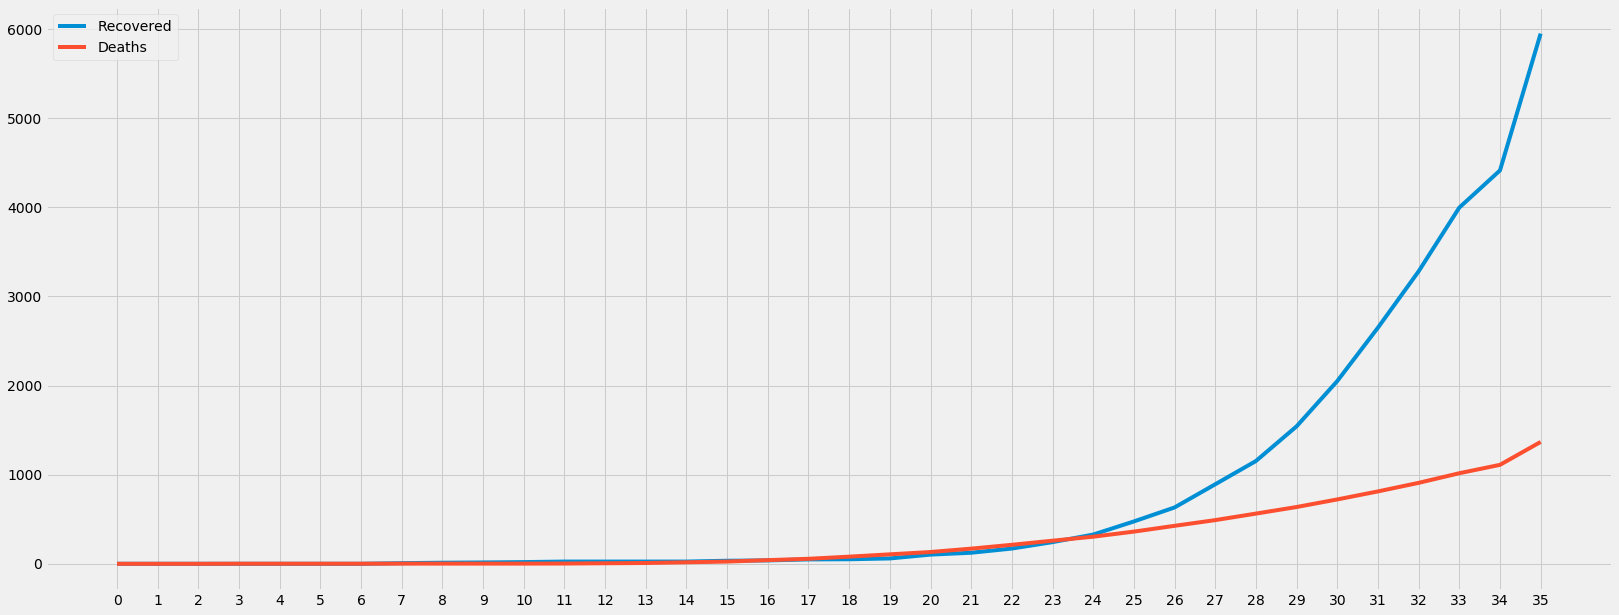

In [13]:
df_d = df['Deaths']
df_r = df['Recovered']
print('RECOVERIES vs. FATALITIES')
df_r.plot(xticks=df.index)
df_d.plot(xticks=df.index)
plt.legend()
plt.show()

Suspected CASES
***************
a =  2637.638988351571
b =  0.0860449558605796
c =  -5080.364781280529
R^2 = 0.9467
Next predicted data point   36,321
         7 Days from Now    70,533
        14 Days from Now    133,016
        21 Days from Now    247,131
        28 Days from Now    455,543
        30 Days from Now    542,041


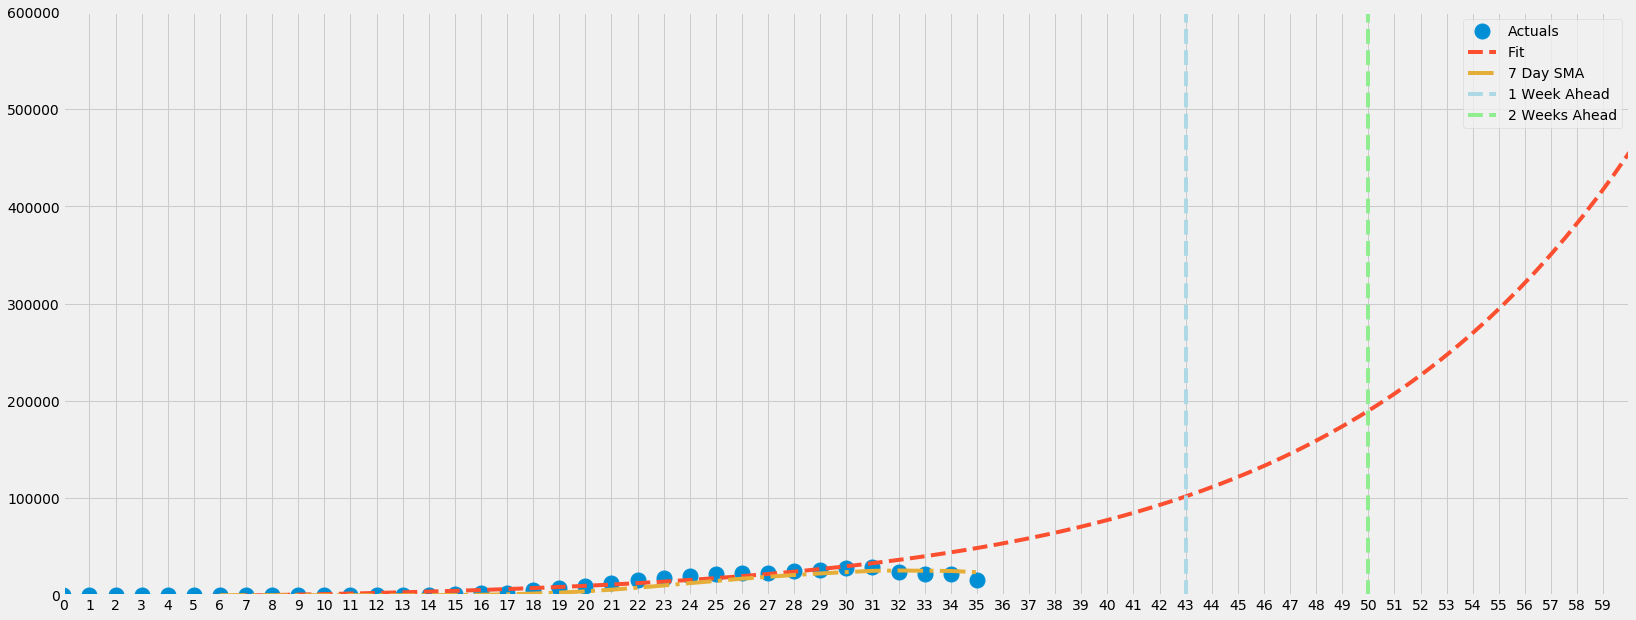

Suspected CASES
***************
a =  2637.638988351571
b =  0.0860449558605796
c =  -5080.364781280529
R^2 = 0.9467
Next predicted data point   36,321
         7 Days from Now    70,533
        14 Days from Now    133,016
        21 Days from Now    247,131
        28 Days from Now    455,543
        30 Days from Now    542,041


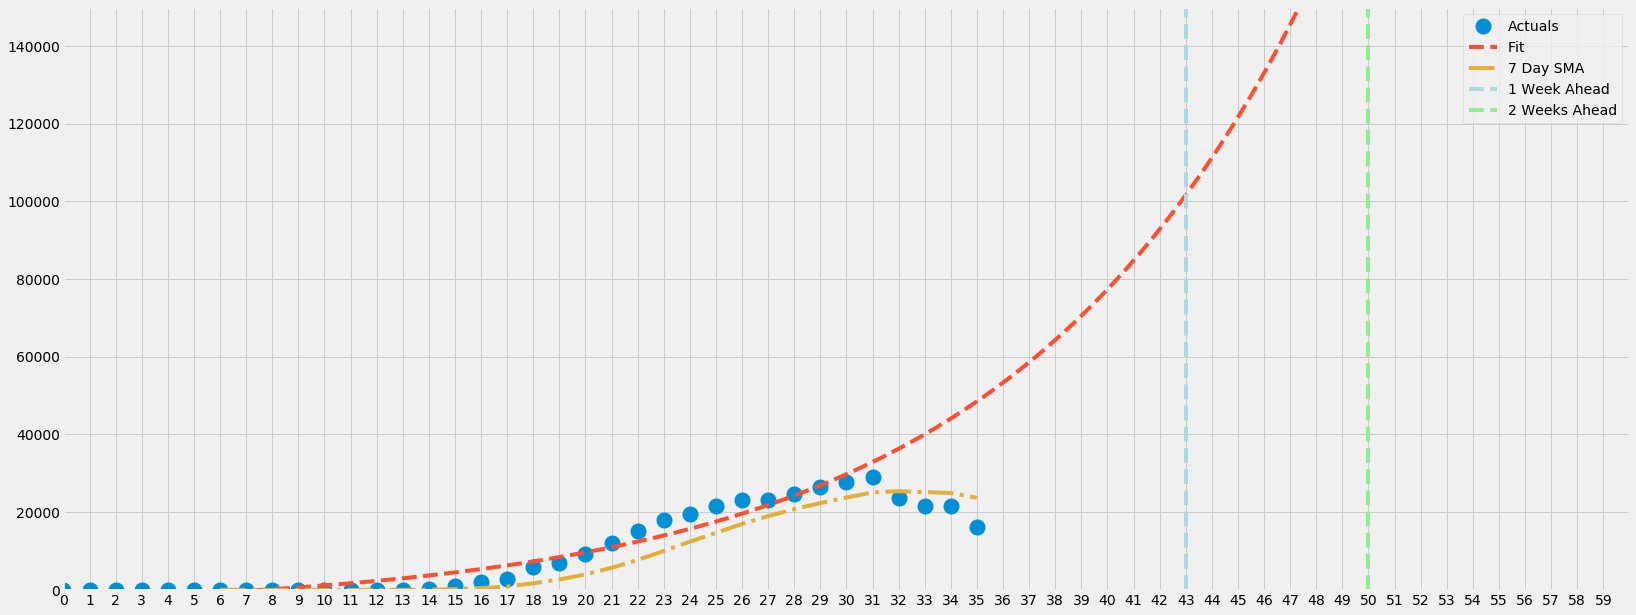

Suspected CASES
***************
a =  2637.638988351571
b =  0.0860449558605796
c =  -5080.364781280529
R^2 = 0.9467
Next predicted data point   36,321
         7 Days from Now    70,533
        14 Days from Now    133,016
        21 Days from Now    247,131
        28 Days from Now    455,543
        30 Days from Now    542,041


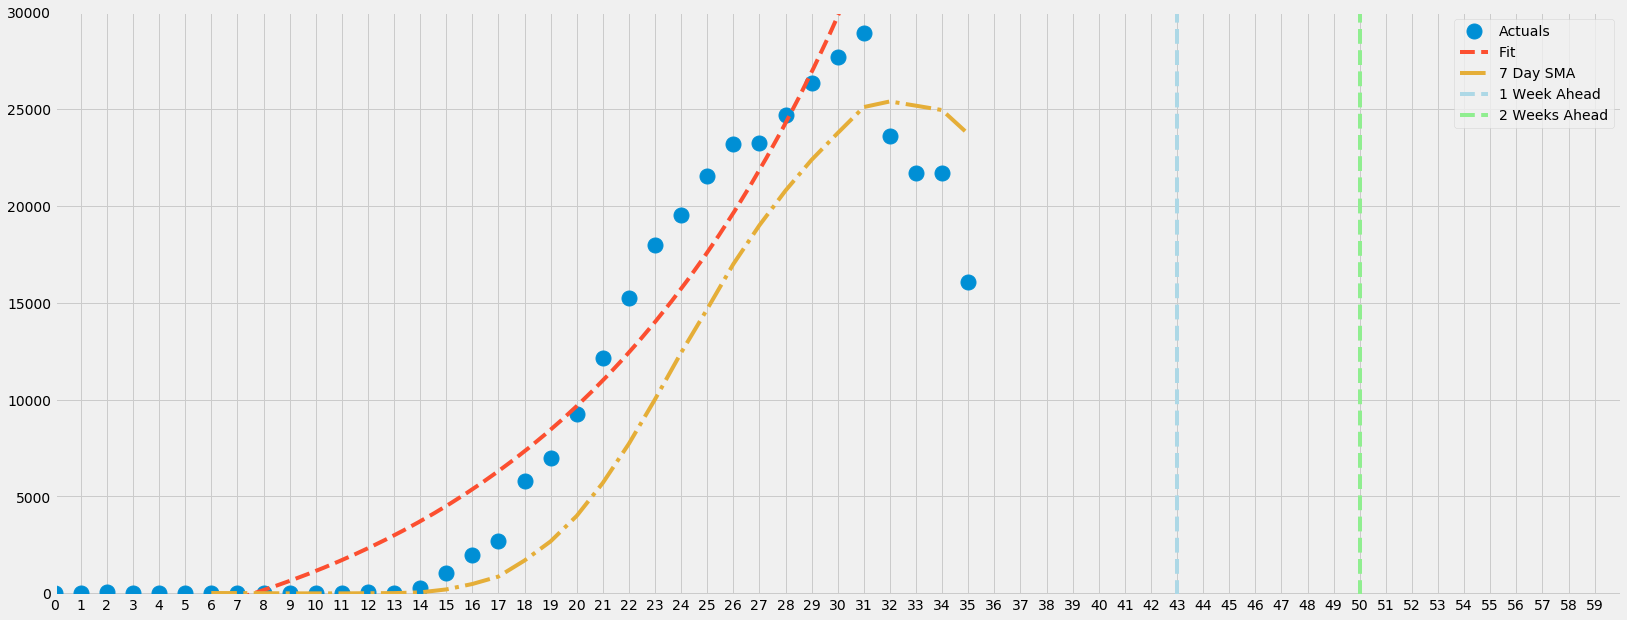

In [14]:
# test_data = 1
points = 4
length = df_sc.count()
n = length - points
print('Suspected CASES')
print('***************')
sm.proj(df_sc,n,600000)
print('Suspected CASES')
print('***************')
sm.proj(df_sc,n,150000)
print('Suspected CASES')
print('***************')
sm.proj(df_sc,n,30000)

Daily New Cases & Fatalities


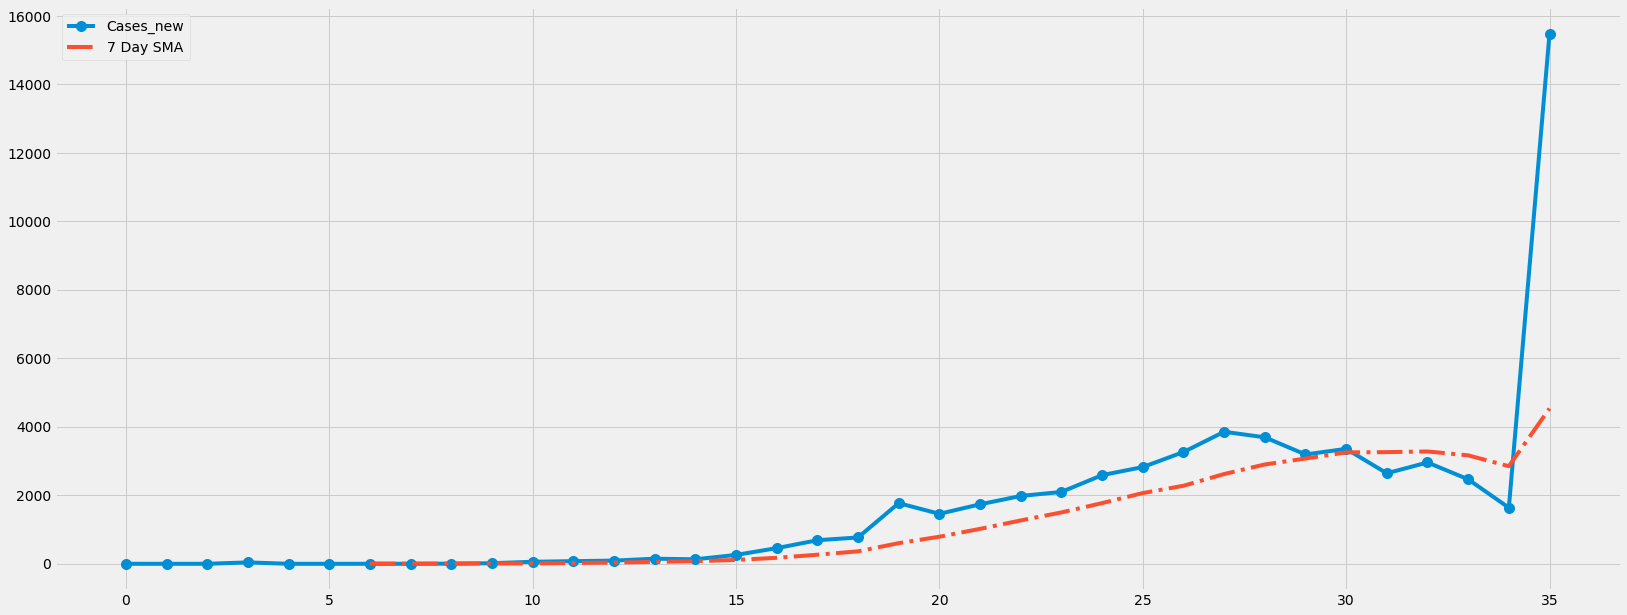

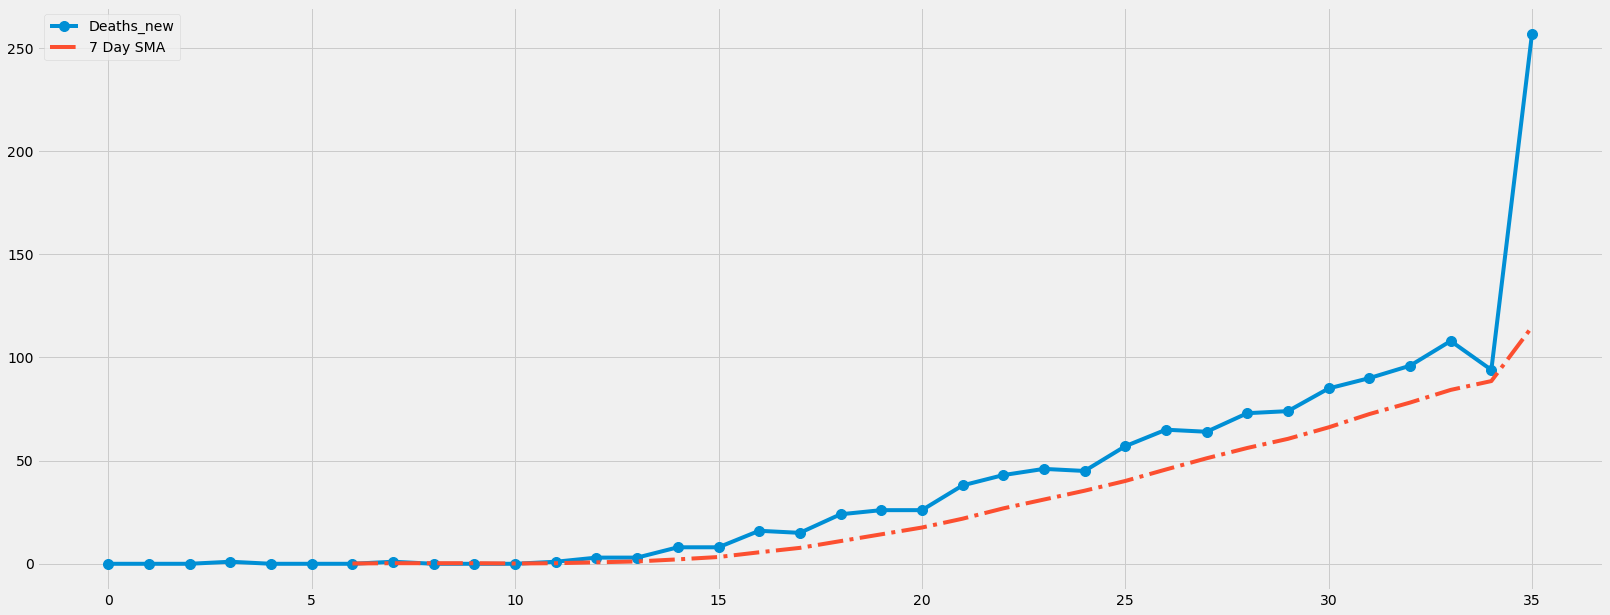

In [15]:
df=df.fillna(0)
df_cp = df['Cases_pct']
df_cn = df['Cases_new']
df_dp = df['Deaths_pct']
df_dn = df['Deaths_new']
print('Daily New Cases & Fatalities')

rcParams['figure.figsize'] = 25,10
df['Cases_new'].plot(marker='o', markersize = 10)
sma = df_cn.rolling(7, min_periods=7, center=False, win_type=None, on=None, axis=0, closed=None).mean()
plt.plot(sma, '-.', markersize = 7, label = '7 Day SMA')
plt.legend()
plt.show()
df['Deaths_new'].plot(marker='o', markersize = 10)
sma = df_dn.rolling(7, min_periods=7, center=False, win_type=None, on=None, axis=0, closed=None).mean()
plt.plot(sma, '-.', markersize = 7, label = '7 Day SMA')
plt.legend()
plt.show()

DAILY NEW CASES
***************
a =  93.2927616330655
b =  0.14069377932902072
c =  -242.61331618860143
R^2 = 0.9741
Next predicted data point   4,552
         7 Days from Now    12,594
        14 Days from Now    34,125
        21 Days from Now    91,775
        28 Days from Now    246,128
        30 Days from Now    326,191


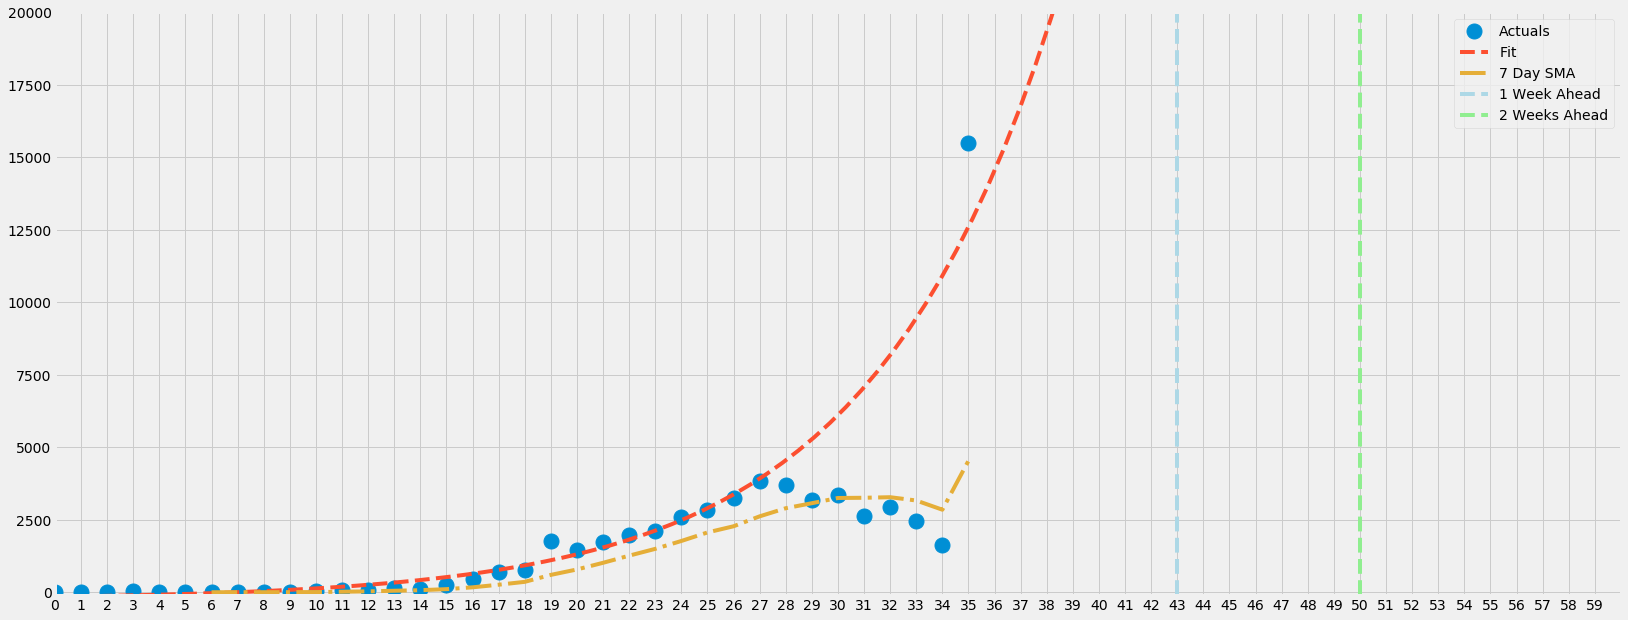

DAILY NEW CASES
***************
a =  93.2927616330655
b =  0.14069377932902072
c =  -242.61331618860143
R^2 = 0.9741
Next predicted data point   4,552
         7 Days from Now    12,594
        14 Days from Now    34,125
        21 Days from Now    91,775
        28 Days from Now    246,128
        30 Days from Now    326,191


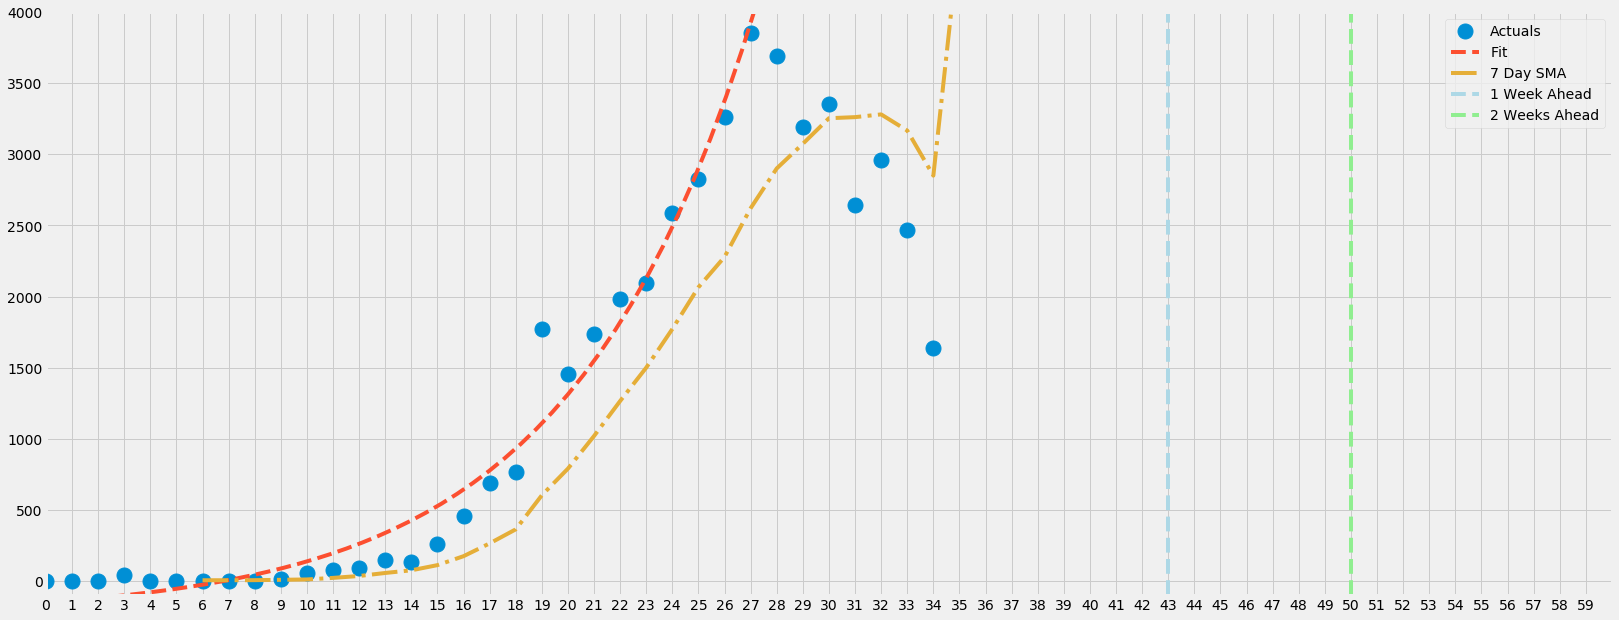

In [16]:
# test_data = 1
points = 8
length = df_cn.count()
n = length - points
print('DAILY NEW CASES')
print('***************')
sm.proj(df_cn,n,20000)

print('DAILY NEW CASES')
print('***************')
sm.proj(df_cn,n,4000)

DAILY NEW FATALITIES
***************
a =  8.95261143562363
b =  0.07997889695815476
c =  -14.926618712173122
R^2 = 0.9839
Next predicted data point   121
         7 Days from Now    223
        14 Days from Now    401
        21 Days from Now    713
        28 Days from Now    1,260
        30 Days from Now    1,481


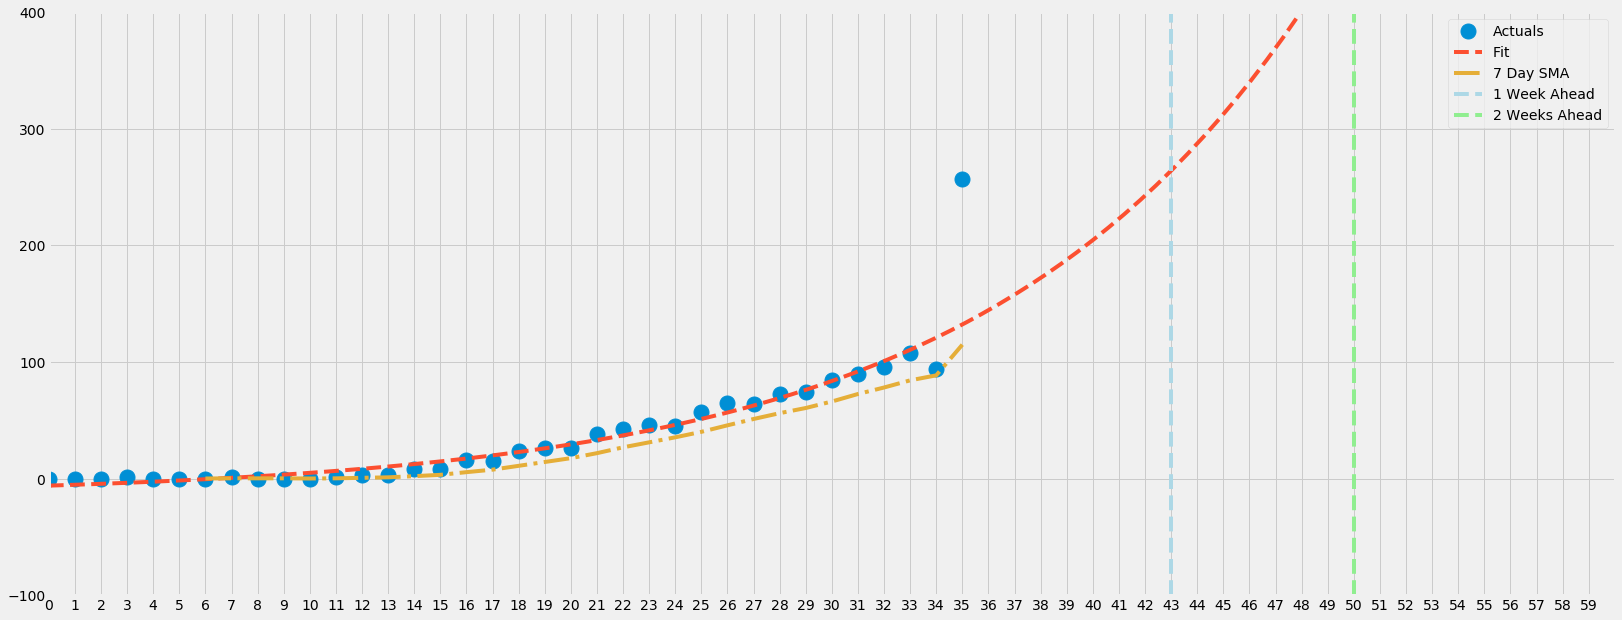

DAILY NEW FATALITIES
***************
a =  8.95261143562363
b =  0.07997889695815476
c =  -14.926618712173122
R^2 = 0.9839
Next predicted data point   121
         7 Days from Now    223
        14 Days from Now    401
        21 Days from Now    713
        28 Days from Now    1,260
        30 Days from Now    1,481


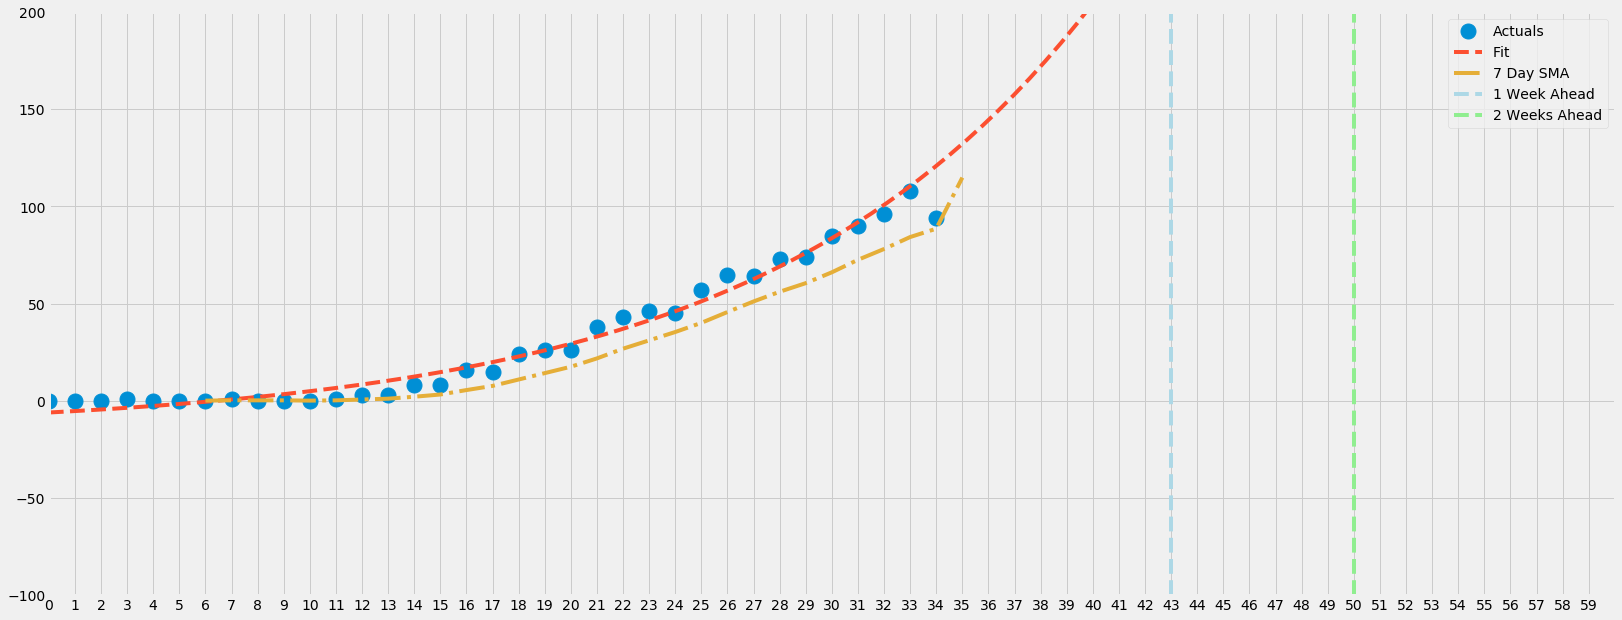

In [17]:
# test_data = 1
points = 2
length = df_dn.count()
n = length - points
print('DAILY NEW FATALITIES')
print('***************')
sm.proj(df_dn,n,400)
print('DAILY NEW FATALITIES')
print('***************')
sm.proj(df_dn,n,200)

CONFIRMED CASES
***************
a =  1182.1885678416536
b =  0.11253857235899306
c =  -3273.2829725738993
R^2 = 0.9819
Next predicted data point   64,676
         7 Days from Now    146,112
        14 Days from Now    325,148
        21 Days from Now    718,756
        28 Days from Now    1,584,100
        30 Days from Now    1,984,784


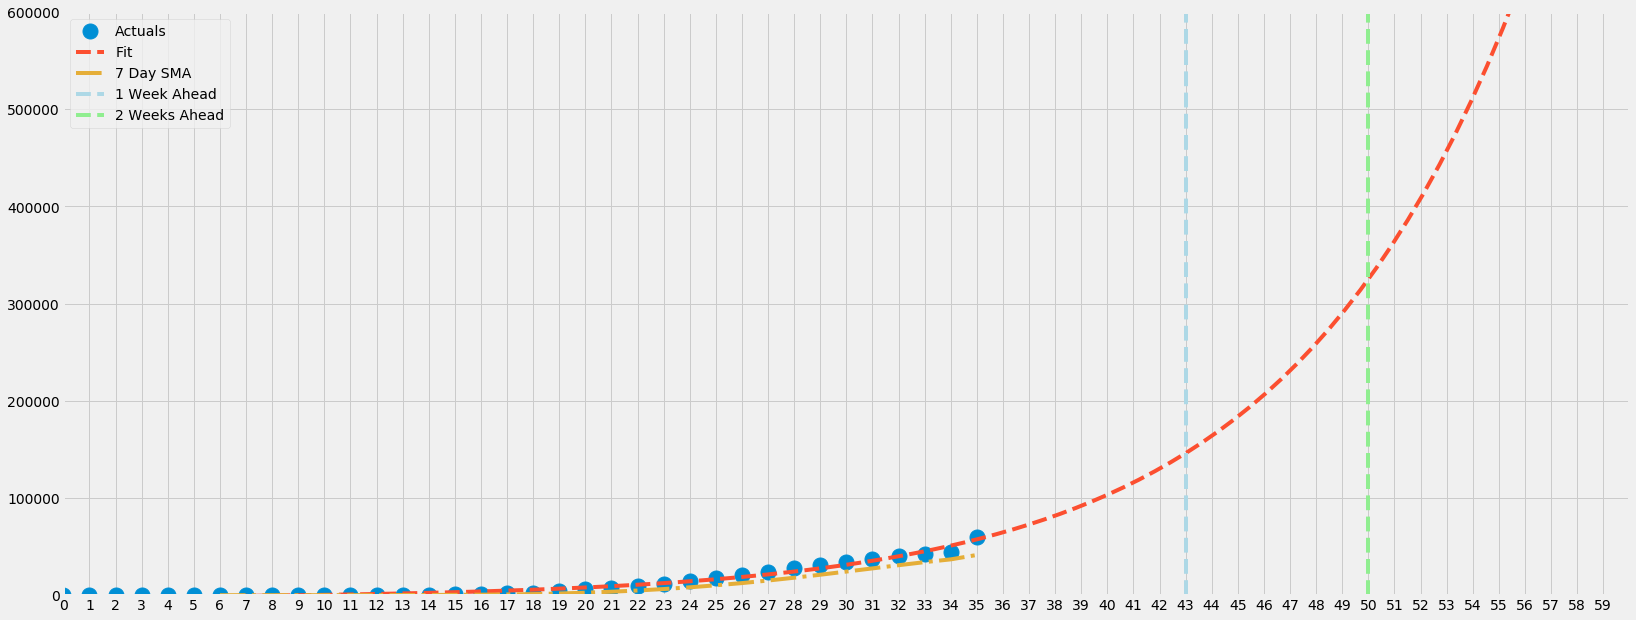

CONFIRMED CASES
***************
a =  1182.1885678416536
b =  0.11253857235899306
c =  -3273.2829725738993
R^2 = 0.9819
Next predicted data point   64,676
         7 Days from Now    146,112
        14 Days from Now    325,148
        21 Days from Now    718,756
        28 Days from Now    1,584,100
        30 Days from Now    1,984,784


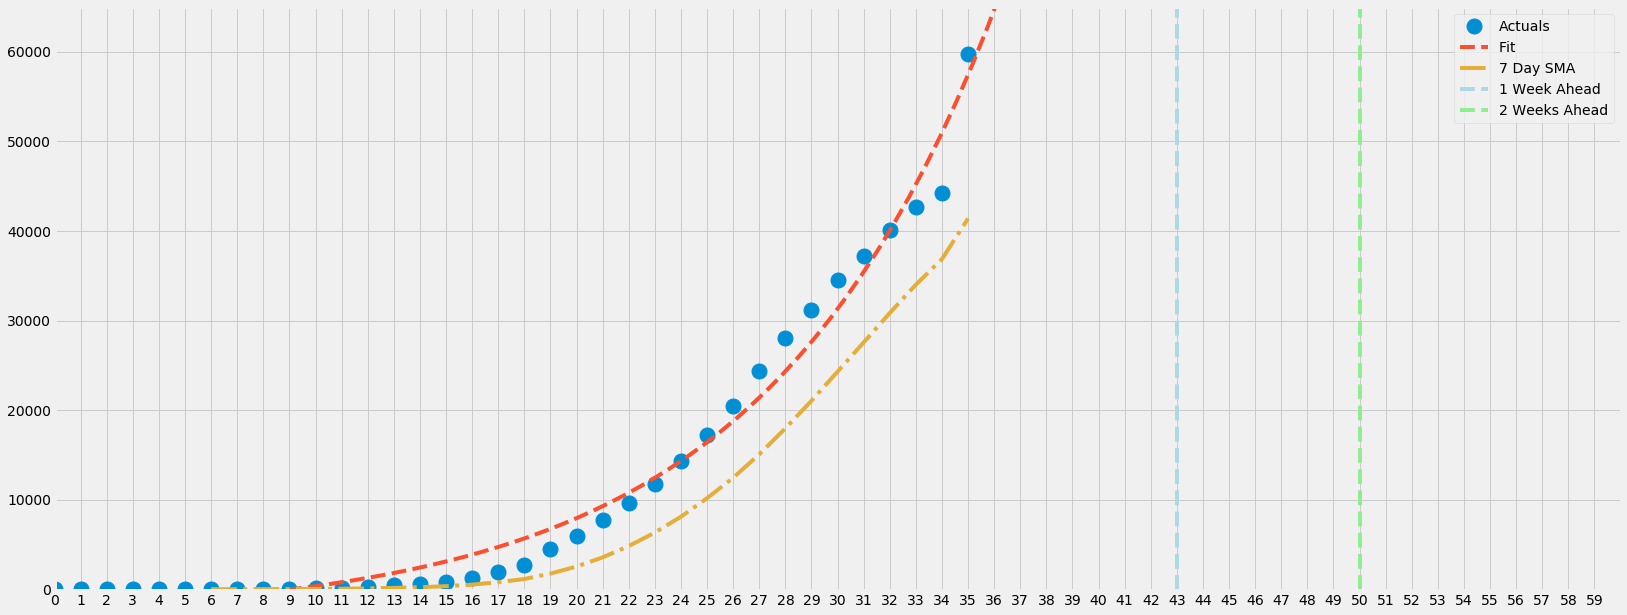

In [18]:
# test_data = 1
points = 0
length = df_cc.count()
n = length - points

print('CONFIRMED CASES')
print('***************')
sm.proj(df_cc,n,600000)
print('CONFIRMED CASES')
print('***************')
sm.proj(df_cc,n,65000)

CONFIRMED CASES outside Mainland China
**************************************


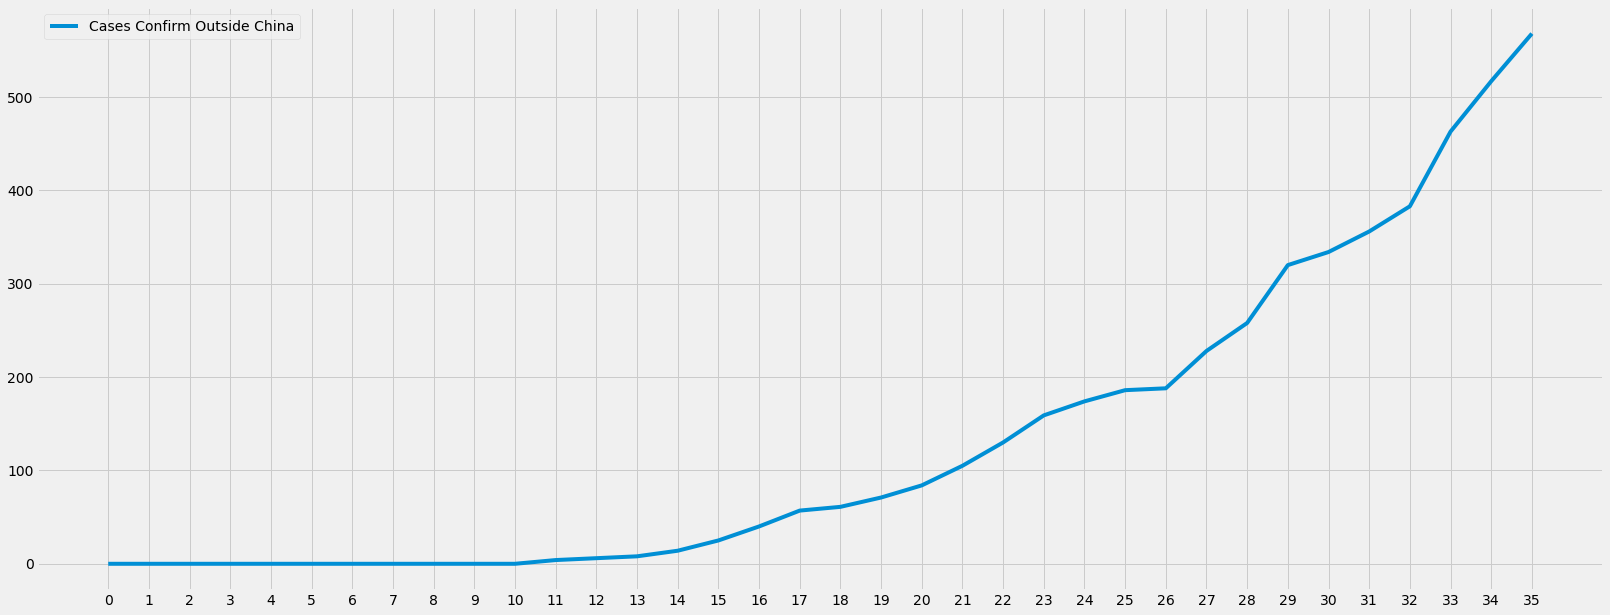

In [19]:
print('CONFIRMED CASES outside Mainland China')
print('**************************************')
df_cco.plot(xticks=df.index)
plt.legend()
plt.show()

CONFIRMED CASES outside Mainland China - Exponential Model
**********************************************************
a =  14.598837440286218
b =  0.10644124186825381
c =  -31.38067727255892
R^2 = 0.9941
Next predicted data point   642
         7 Days from Now    1,388
        14 Days from Now    2,959
        21 Days from Now    6,267
        28 Days from Now    13,238
        30 Days from Now    16,385


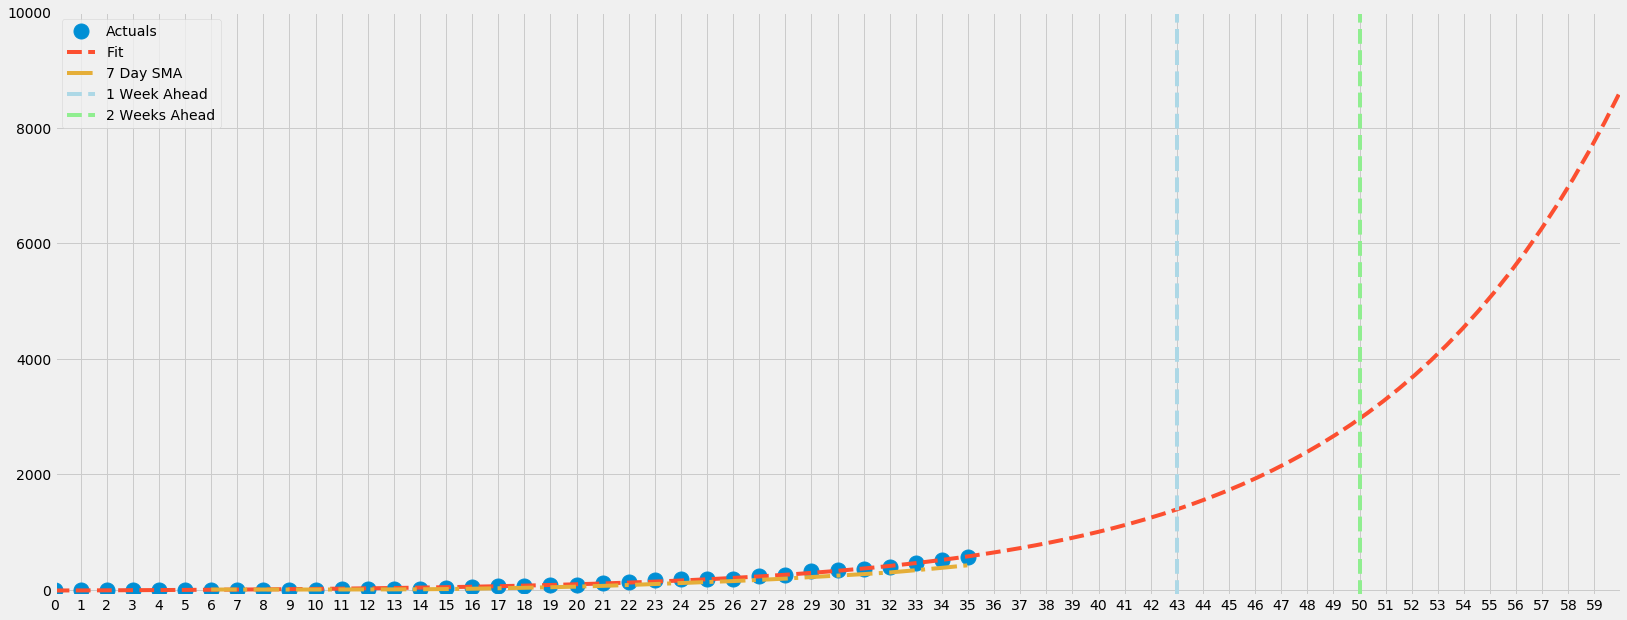

CONFIRMED CASES outside Mainland China - Exponential Model
**********************************************************
a =  14.598837440286218
b =  0.10644124186825381
c =  -31.38067727255892
R^2 = 0.9941
Next predicted data point   642
         7 Days from Now    1,388
        14 Days from Now    2,959
        21 Days from Now    6,267
        28 Days from Now    13,238
        30 Days from Now    16,385


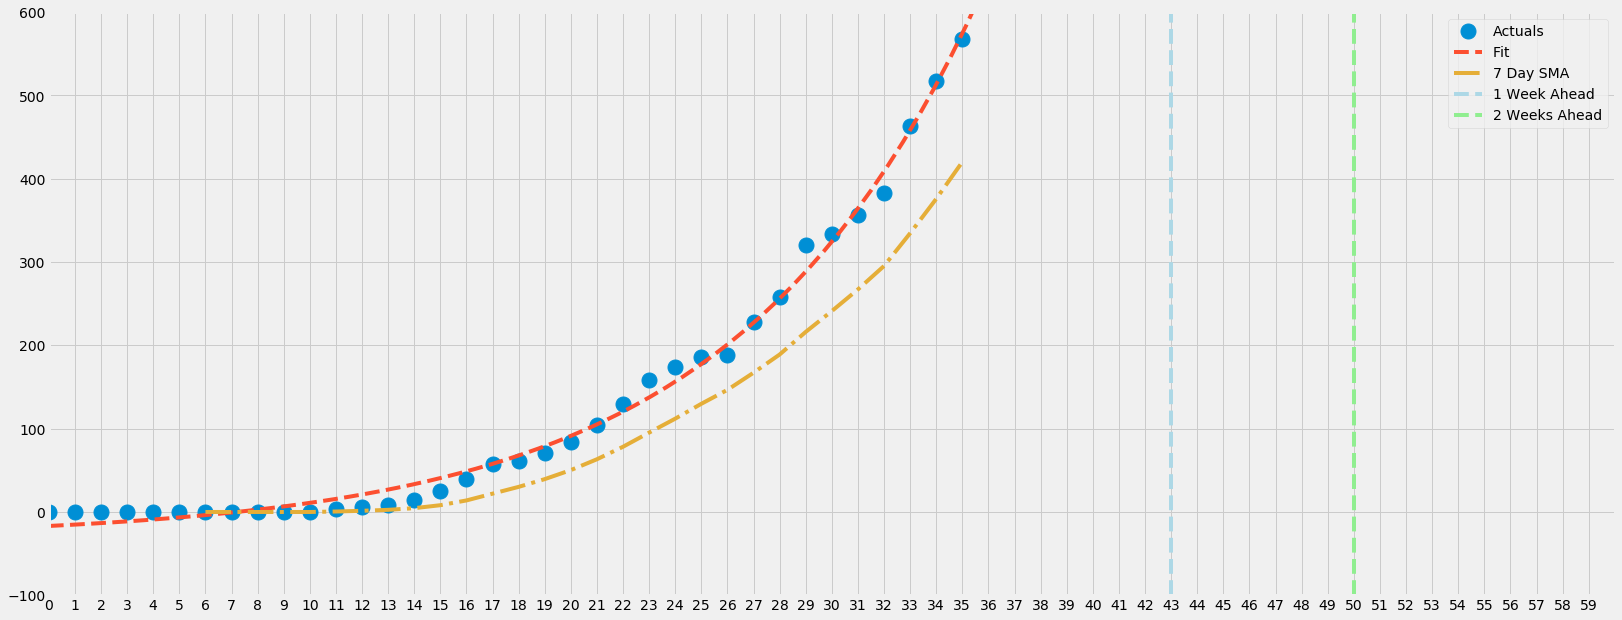

In [20]:
df_cco=df_cco.fillna(0)
# test_data = 1
points = 0
length = df_cco.count()
n = length - points
print('CONFIRMED CASES outside Mainland China - Exponential Model')
print('**********************************************************')
sm.proj(df_cco,n,10000)
print('CONFIRMED CASES outside Mainland China - Exponential Model')
print('**********************************************************')
sm.proj(df_cco,n,600)

RECOVERIES vs. FATALITIES Outside of China


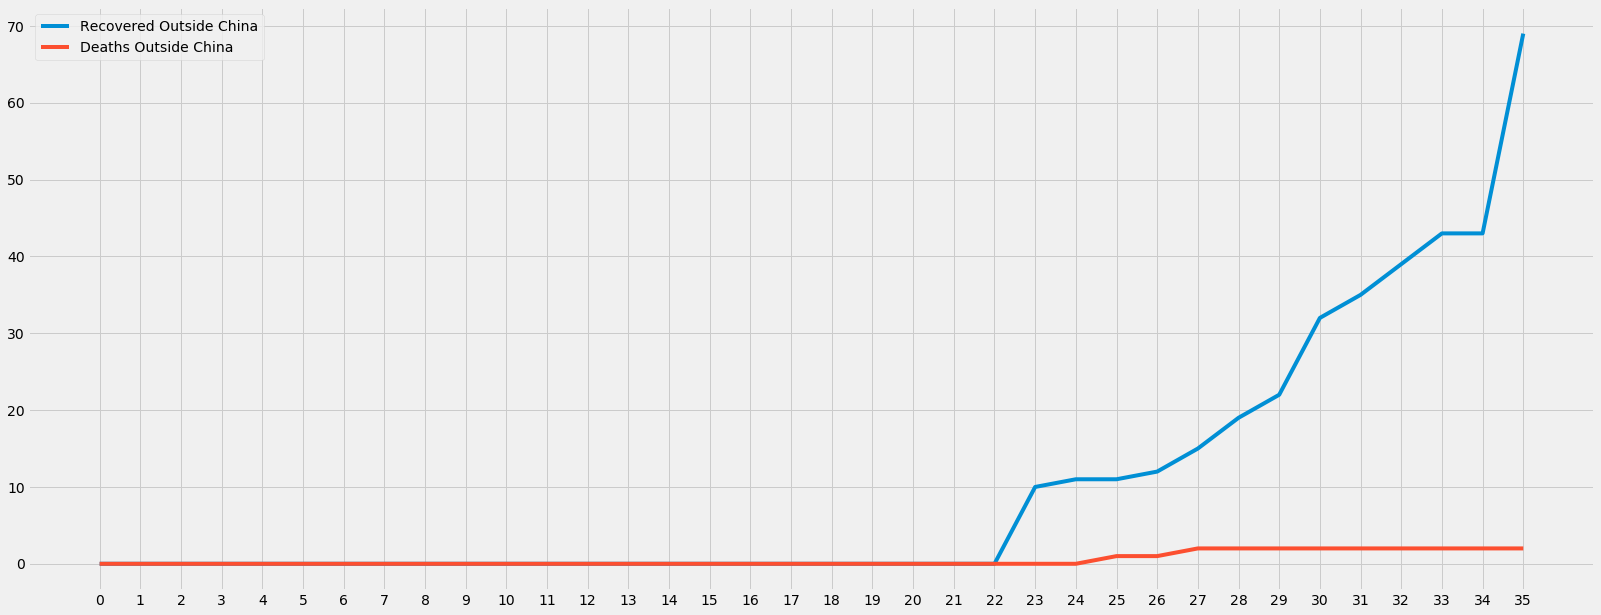

In [21]:
df_do = df['Deaths Outside China']
df_ro = df['Recovered Outside China']
print('RECOVERIES vs. FATALITIES Outside of China')
df_ro.plot(xticks=df.index)
df_do.plot(xticks=df.index)
plt.legend()
plt.show()

FATALITIES
**********
a =  16.880700273555533
b =  0.12615684747991696
c =  -50.31071931633838
R^2 = 0.9948
Next predicted data point   1,534
         7 Days from Now    3,781
        14 Days from Now    9,215
        21 Days from Now    22,356
        28 Days from Now    54,137
        30 Days from Now    69,689


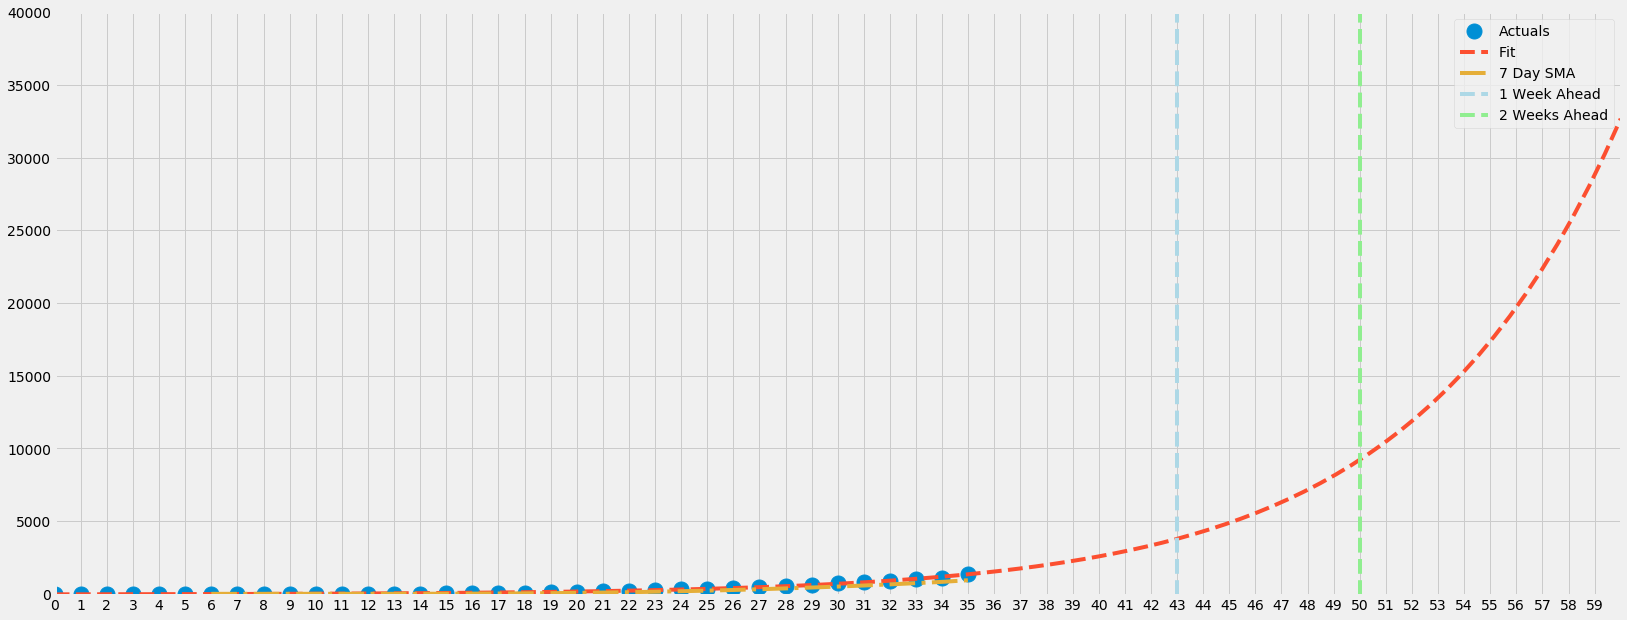

FATALITIES
**********
a =  16.880700273555533
b =  0.12615684747991696
c =  -50.31071931633838
R^2 = 0.9948
Next predicted data point   1,534
         7 Days from Now    3,781
        14 Days from Now    9,215
        21 Days from Now    22,356
        28 Days from Now    54,137
        30 Days from Now    69,689


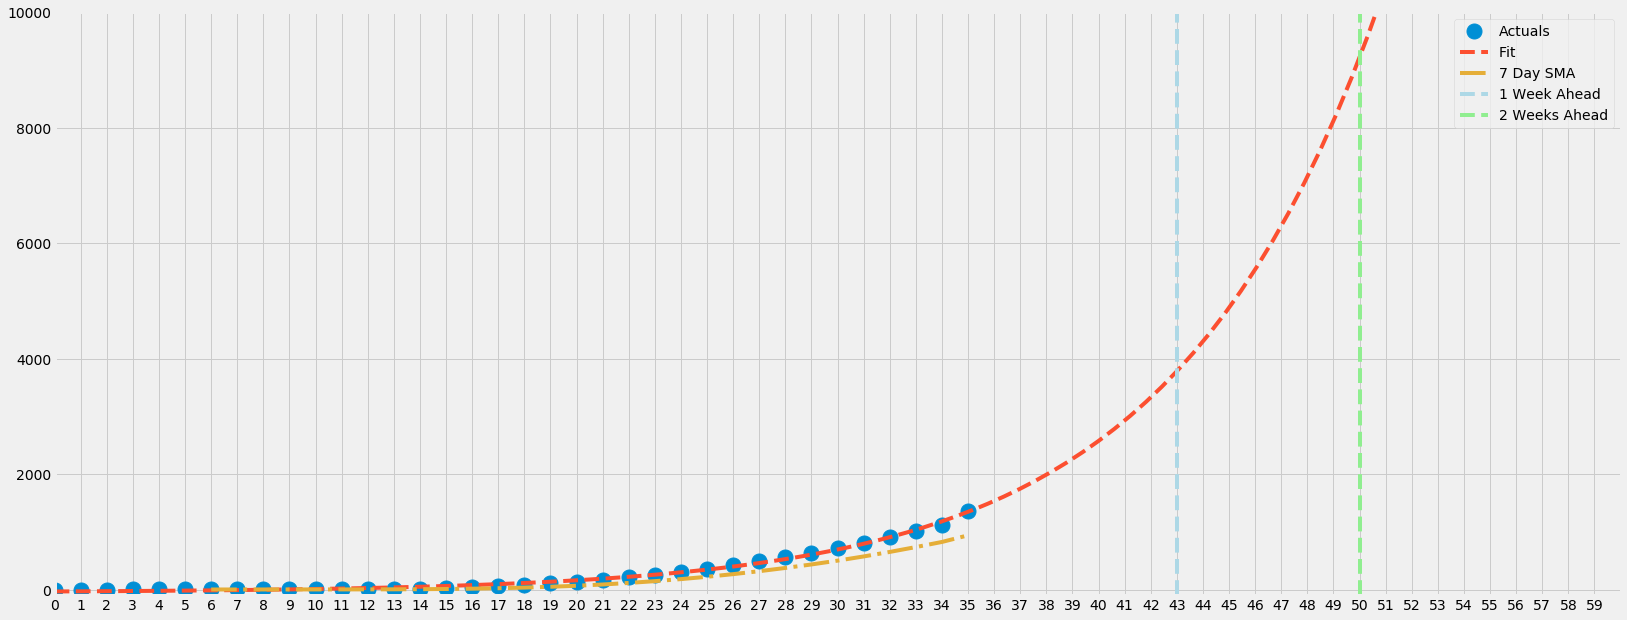

FATALITIES
**********
a =  16.880700273555533
b =  0.12615684747991696
c =  -50.31071931633838
R^2 = 0.9948
Next predicted data point   1,534
         7 Days from Now    3,781
        14 Days from Now    9,215
        21 Days from Now    22,356
        28 Days from Now    54,137
        30 Days from Now    69,689


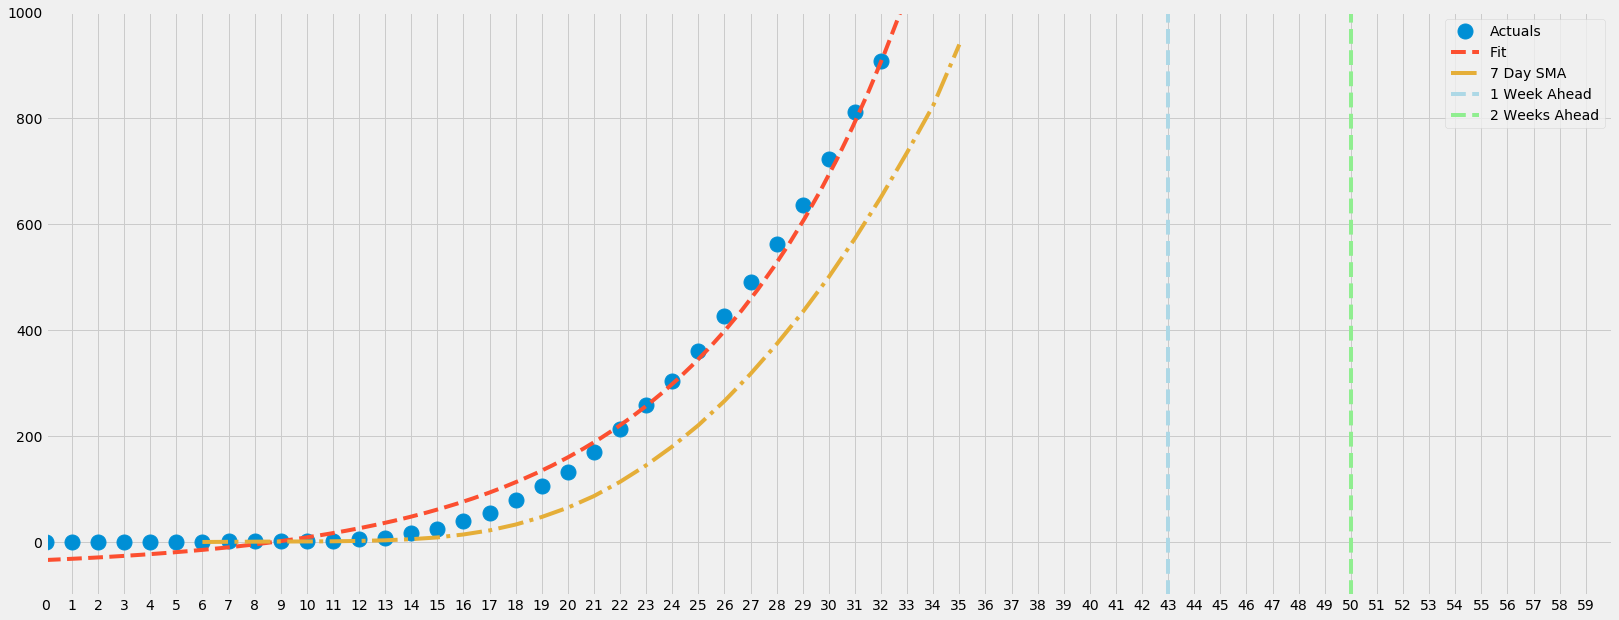

In [22]:
# test_data = 1
points = 0
length = df_d.count()
print('FATALITIES')
print('**********')
n = length - points
sm.proj(df_d,n, 40000)
print('FATALITIES')
print('**********')
sm.proj(df_d,n, 10000)
print('FATALITIES')
print('**********')
sm.proj(df_d,n, 1000)

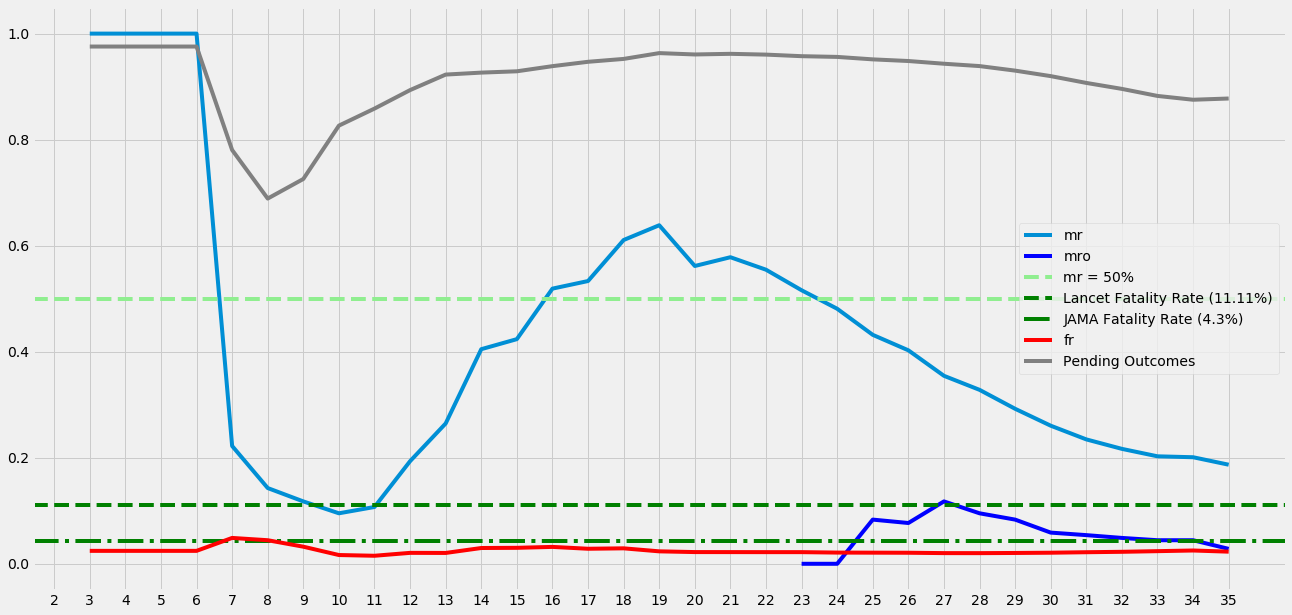

Estimating future fatalities using various rates based on insights from the data
Outcomes Pending in China = 88%
MR Based Fatalities =     11,168
Lancet Based Fatalities = 6,640
MRO Based::        China = 1,683
JAMA Based Fatalities    = 2,570
MRO Based::Outside China = 16
JAMA Based Fatalities    = 24
Current:                       FR  =  2%
                               MR  = 19%
                               MRO = 3%
Reference [RED Dot] from Lancet Study 11%
Reference [Green Dot] from JAMA Paper 4%


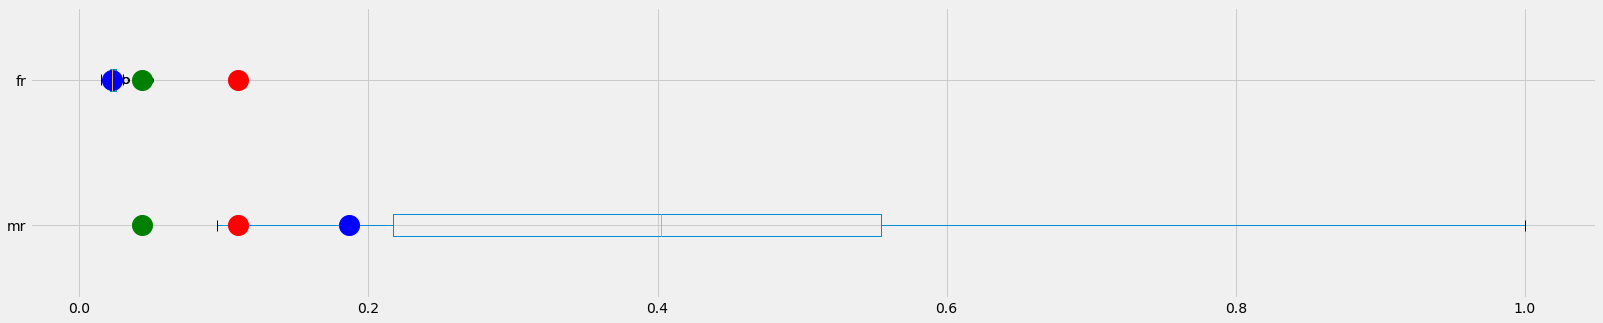

In [23]:
# MR % = Fatalities / (Fatalities + Recovered)
rcParams['figure.figsize'] = 20,10

df['mr'] = df.Deaths/(df.Deaths + df.Recovered)
df.mr.plot()
df['mro'] = df['Deaths Outside China']/(df['Deaths Outside China'] + df['Recovered Outside China'])
df.mro.plot(color='b')

# FR % = Fatalities / Confirmed Cases
df['fr'] = df.Deaths/(df['Cases Confirmed'])
plt.axhline(y=0.5, color='lightgreen', linestyle='--', label = 'mr = 50%')
plt.axhline(y=11/99, color='green', linestyle='--', label = 'Lancet Fatality Rate (11.11%)')
plt.axhline(y=4.3/100, color='green', linestyle='-.', label = 'JAMA Fatality Rate (4.3%)')
df.fr.plot(xticks=df.index, color='r')

#Pending Outcomes
df['po'] = (df['Cases Confirmed'] - df['Deaths'] - df['Recovered'])/df['Cases Confirmed'] 
df['po'].plot(color='grey', label = 'Pending Outcomes')

plt.legend()
plt.show()

print('Estimating future fatalities using various rates based on insights from the data')
print('Outcomes Pending in China = {:0.0%}'.format(df.po.tail(1).values[0]))
print('MR Based Fatalities =     {:,.0f}'.format(df_cc.tail(1).values[0]*df.mr.tail(1).values[0]))
print('Lancet Based Fatalities = {:,.0f}'.format(df_cc.tail(1).values[0]*11/99))
print('MRO Based::        China = {:,.0f}'.format(df_cc.tail(1).values[0]*df.mro.tail(1).values[0]))
print('JAMA Based Fatalities    = {:,.0f}'.format(df_cc.tail(1).values[0]*4.3/100))
print('MRO Based::Outside China = {:,.0f}'.format(df_cco.tail(1).values[0]*df.mro.tail(1).values[0]))
print('JAMA Based Fatalities    = {:,.0f}'.format(df_cco.tail(1).values[0]*4.3/100))

b=df.fr[len(df)-1]
print('Current:                       FR  =  {:.0%}'.format(b))
a=df.mr[len(df)-1]
print('                               MR  = {:.0%}'.format(a))
print('                               MRO = {:,.0%}'.format(df.mro.tail(1).values[0]))
print('Reference [RED Dot] from Lancet Study {:.0%}'.format(11/99))
print('Reference [Green Dot] from JAMA Paper {:.0%}'.format(.043))

#Boxplots
rcParams['figure.figsize'] = 25,5
df.boxplot(column=['mr','fr'], vert = False)
plt.plot(a, [1], marker='o', markersize=20, color="blue")
plt.plot(b, [2], marker='o', markersize=20, color="blue")
plt.plot(.11, [1], marker='o', markersize=20, color="Red")
plt.plot(.11, [2], marker='o', markersize=20, color="Red")
plt.plot(.043, [1], marker='o', markersize=20, color="Green")
plt.plot(.043, [2], marker='o', markersize=20, color="Green")
plt.show()

Reference Rates: https://en.wikipedia.org/wiki/List_of_human_disease_case_fatality_rates

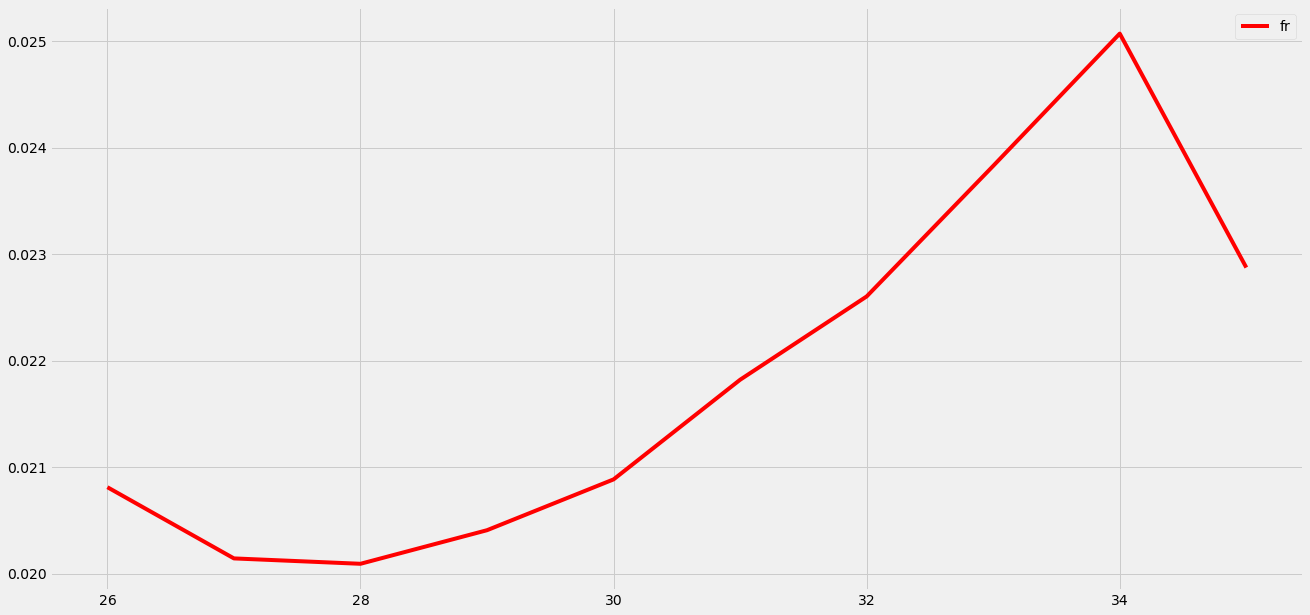

In [24]:
rcParams['figure.figsize'] = 20,10
df.fr.tail(10).plot( color='r')
plt.legend()
plt.show()
